1. Import libraries


In [24]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use("Agg")  # important for non-interactive image generation
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo
import subprocess
from PIL import Image
# from inky.auto import auto

%matplotlib inline

lat = 51.0501
lon = -114.0853
tz = "America/Denver"


## Graphs


In [25]:
def plot_hourly_graph(data, now):

    # hourly_temps = data['hourly']['temperature_2m'].astype(int)

    hourly_temps = pd.Series(
        data['hourly']['temperature_2m']).round().astype(int)

    hourly_times = data['hourly']['time']

    local_tz = ZoneInfo(tz)

    # Convert API times to timezone-aware datetimes
    times = [datetime.fromisoformat(t).astimezone(local_tz)
             for t in hourly_times]

    # Build DataFrame
    df = pd.DataFrame({"time": times, "hourly_temps": hourly_temps})
    df = df.set_index("time")

    # Current time truncated to the hour
    current_hour = now.replace(minute=0, second=0, microsecond=0)

    # Slice to next 12 hours
    df = df[df.index >= current_hour]
    df = df[df.index <= current_hour + pd.Timedelta(hours=12)]

    df.index = df.index.tz_localize(None)
    plt.figure(figsize=(10, 3))
    plt.plot(df.index, df['hourly_temps'])

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))

    # plt.xlabel("Hour")
    # plt.ylabel("Temperature (C)")
    plt.xlim(df.index[0], df.index[-1])

    # Add horizontal lines every 5 degrees
    y_min = int(df['hourly_temps'].min() // 5 * 5)  # round down to nearest 5
    y_max = int(df['hourly_temps'].max() // 5 * 5 + 5)  # round up to nearest 5
    plt.yticks(np.arange(y_min, y_max + 1, 5))
    plt.ylabel(None)
    plt.yticks([])

    for xi in df.index:
        yi = df.loc[xi, 'hourly_temps']
        plt.annotate(f'{yi}', (xi, yi),
                     textcoords="offset points",
                     xytext=(0, 10),
                     ha='center',
                     fontsize=16)

    plt.xticks(fontsize=16)
    plt.fill_between(df.index, df['hourly_temps'], color='skyblue', alpha=0.5)

    # optional: dashed grid lines
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout()
    for spine in plt.gca().spines.values():
        spine.set_visible(False)

    # save as PNG
    plt.savefig("./static/graphs/hourly_forecast_12.png", transparent=True)
    # plt.close()                          # close figure (important on Pi headless)
    plt.show()

2. Fetch weather data


In [26]:
def get_weather():

    from datetime import datetime, timedelta
    from zoneinfo import ZoneInfo

    with open("./data/wmo_code.json") as file:
        wmo_code = json.load(file)

    url = "https://api.open-meteo.com/v1/forecast"

    params = {
        "latitude": lat,
        "longitude": lon,
        "daily": ["sunrise", "sunset", "daylight_duration", "sunshine_duration", "uv_index_max", "precipitation_probability_max", "temperature_2m_max", "temperature_2m_min"],
        "hourly": ["temperature_2m", "relative_humidity_2m", "dew_point_2m", "apparent_temperature", "precipitation", "precipitation_probability", "rain", "showers", "snowfall", "snow_depth", "visibility", "wind_speed_10m", "wind_direction_10m", "wind_gusts_10m", "uv_index", "is_day", "weather_code"],
        "models": "best_match",
        "current": ["temperature_2m", "relative_humidity_2m", "apparent_temperature", "is_day", "wind_speed_10m", "wind_direction_10m", "wind_gusts_10m", "weather_code"],
        "timezone": tz,
    }

    r = requests.get(url, params=params)
    data = r.json()

    local_tz = ZoneInfo(tz)
    now = datetime.now(local_tz)

    print(data)

    plot_hourly_graph(data, now.replace(minute=0, second=0, microsecond=0))
    # return data

    is_day = "day" if data["current"]["is_day"] else "night"

    day_str = now.strftime("%A %B %d")
    time_str = now.strftime("%-I:%M %p").lower()

    wind_speed = data["current"]["wind_speed_10m"]
    wind_dir = data["current"]["wind_direction_10m"]
    wind_gust = data["current"]["wind_gusts_10m"]

    wind_str = f"{wind_speed} km/h {wind_dir}° (gusting to {wind_gust} km/h)"

    return {
        "TEMP": data["current"]["temperature_2m"],
        "FEELS": data["current"]["apparent_temperature"],
        "HUMIDITY": data["current"]["relative_humidity_2m"],
        "WIND": wind_speed,
        "DESC": wmo_code[str(data["current"]["weather_code"])][is_day]['description'],
        "CURRENT_ICON": wmo_code[str(data["current"]["weather_code"])][is_day]['icon'],
        "PRECIP%": data["daily"]["precipitation_probability_max"][0],
        "TIME": "Last Updated: " + time_str,
        "DAY": day_str,
        "HIGH": data["daily"]["temperature_2m_max"][0],
        "LOW": data["daily"]["temperature_2m_min"][0],
    }
    # "time": datetime.datetime.now().strftime("%Y-%m-%d %H:%M")

In [27]:
def render_html(weather):
    # Load template
    with open("./templates/template.html", "r") as f:
        html = f.read()

    # Loop through keys in the weather dictionary
    for key, value in weather.items():
        placeholder = f"{{{{{key}}}}}"   # builds {{TEMP}}, {{FEELS}}, etc.
        html = html.replace(placeholder, str(value))

    # Save output
    with open("./templates/output.html", "w") as f:
        f.write(html)

    print("Saved output.html!")

In [28]:

# --- 3. Run Chromium headless to screenshot ---
def make_screenshot():
    subprocess.run([
        "chromium-browser",
        "--headless",
        "--disable-gpu",
        "--window-size=800,480",
        f"--screenshot=screen.png",
        "output.html"
    ])

In [29]:
# --- 4. Display screenshot on Inky ---
def show_on_inky():
    display = auto()
    img = Image.open("screen.png")
    display.set_image(img)
    display.show()

{'latitude': 51.054447, 'longitude': -114.07635, 'generationtime_ms': 0.7444620132446289, 'utc_offset_seconds': -25200, 'timezone': 'America/Denver', 'timezone_abbreviation': 'GMT-7', 'elevation': 1043.0, 'current_units': {'time': 'iso8601', 'interval': 'seconds', 'temperature_2m': '°C', 'relative_humidity_2m': '%', 'apparent_temperature': '°C', 'is_day': '', 'wind_speed_10m': 'km/h', 'wind_direction_10m': '°', 'wind_gusts_10m': 'km/h', 'weather_code': 'wmo code'}, 'current': {'time': '2025-12-14T07:45', 'interval': 900, 'temperature_2m': 0.8, 'relative_humidity_2m': 56, 'apparent_temperature': -4.0, 'is_day': 0, 'wind_speed_10m': 12.6, 'wind_direction_10m': 90, 'wind_gusts_10m': 12.6, 'weather_code': 3}, 'hourly_units': {'time': 'iso8601', 'temperature_2m': '°C', 'relative_humidity_2m': '%', 'dew_point_2m': '°C', 'apparent_temperature': '°C', 'precipitation': 'mm', 'precipitation_probability': '%', 'rain': 'mm', 'showers': 'mm', 'snowfall': 'cm', 'snow_depth': 'm', 'visibility': 'm', 

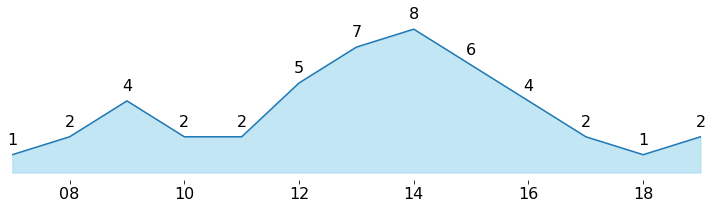

Saved output.html!


In [30]:
# --- Main program ---
if __name__ == "__main__":
    weather = get_weather()
    render_html(weather)
    # print(weather)
    # make_screenshot()
    # show_on_inky()

In [31]:
# from IPython.display import HTML

# # template.html

# with open("./templates/output.html", "r") as f:
#     html_content = f.read()

# HTML(html_content)